## Text Analysis for Helpfulness of the Amazon Product Reviews

In this notebook, we'll perform a text analysis with Amazon product review data for Movies and TV to find meaningful connections between poor ratings on review helpfulness and text properties of the reviews.

The measure to analyze helpfulness will be "helpful rate", which is number of votes given as "helpful" divided by number of all votes.

First, we'll apply a language detection function to see if the different languages affect helpfulness. Then we'll use nltk library for some basic natural language processing operations and we'll look at word frequencies in the reviews with poor helpfulness and try to find a pattern. Finally, we'll perform a topic modeling with a statistic model called "Latent Dirichlet Allocation" to understand if there is some specific topics which affect poor helpfulness.

We'll take a random 20% sample of the data which reduces the time for running the code to approximately 3 hours.

The following are the resources used for this study:
- __[NLP Tutorial Using Python NLTK (Simple Examples)](https://likegeeks.com/nlp-tutorial-using-python-nltk/)__
- __[Ultimate guide to deal with Text Data (using Python) – for Data Scientists & Engineers](https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/)__
- __[Text Data Preprocessing: A Walkthrough in Python](https://www.kdnuggets.com/2018/03/text-data-preprocessing-walkthrough-python.html)__
- __[Beginners Guide to Topic Modeling in Python](https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/)__

Download dataset from __[here](https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/)__

### Table of Contents

1. [Preparing Data](#1)
2. [Effect of Language on Helpfulness](#2)
3. [Text Pre-Processing](#3)
4. [Frequent Words Used In the Reviews with Poor Helpfulness](#4)
5. [Topic Modeling](#5)

***
Lets start with importing necessary libraries:

In [1]:
#Pandas and NumPy libraries for data operations
import pandas as pd
import numpy as np

#Library to load data from gzip file
import gzip

#Libraries and settings to draw charts
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
plt.figure(figsize=(8, 5))
%matplotlib inline

#Library to detect language for a given text
from langdetect import detect

#Library to correct contractions (e.g. "you're" fixed as "you are")
import contractions

#Natural Language Toolkit for Python.
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#Library for string operations
import string

#Hide the warning by gensim library which is not important  
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

#Topic modeling library
import gensim

### <a id="1"></a>1. Preparing Data

***
Define the function to read data from gzip file, as described in the information page of this dataset (http://jmcauley.ucsd.edu/data/amazon/):

In [2]:
def parse(path):
  g = gzip.open(path, "rb")
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient="index")

***
Read data to a Pandas dataframe:

In [3]:
#Read the data with the defined function
df = getDF("reviews_Movies_and_TV_5.json.gz")

***
Extract the number of votes given as "helpful" and the total number of helpfulness votes to 2 separate columns:

In [4]:
df[["helpful1", "helpful2"]] = pd.DataFrame(df.helpful.values.tolist(), index= df.index)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful1,helpful2
0,ADZPIG9QOCDG5,0005019281,"Alice L. Larson ""alice-loves-books""","[0, 0]",This is a charming version of the classic Dick...,4.0,good version of a classic,1203984000,"02 26, 2008",0,0
1,A35947ZP82G7JH,0005019281,Amarah Strack,"[0, 0]",It was good but not as emotionally moving as t...,3.0,Good but not as moving,1388361600,"12 30, 2013",0,0
2,A3UORV8A9D5L2E,0005019281,Amazon Customer,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3.0,Winkler's Performance was ok at best!,1388361600,"12 30, 2013",0,0
3,A1VKW06X1O2X7V,0005019281,"Amazon Customer ""Softmill""","[0, 0]",Henry Winkler is very good in this twist on th...,5.0,It's an enjoyable twist on the classic story,1202860800,"02 13, 2008",0,0
4,A3R27T4HADWFFJ,0005019281,BABE,"[0, 0]",This is one of the best Scrooge movies out. H...,4.0,Best Scrooge yet,1387670400,"12 22, 2013",0,0


***
Remove some faulty or unnecessary records and unnecessary columns. Calculate "helpful rate":

In [5]:
#Remove records if there is no vote for helpfulness
df = df.loc[df["helpful2"] != 0]
#Remove records if the number of votes given as "helpful" greater than the total number of votes (a few occasions)
df = df.loc[df["helpful2"] >= df["helpful1"]]
#Drop columns which won't be necessary anymore
df.drop(["helpful", "reviewTime", "reviewerName"], axis=1, inplace=True)
#Calculate "helpful rate"
df["helpfulRate"]=df["helpful1"]/df["helpful2"]
df.head()

,reviewerID,asin,reviewText,overall,summary,unixReviewTime,helpful1,helpful2,helpfulRate
6,A5NYUBEKXFLX5,0005019281,This is the American adaptation of the Charles...,5.0,A MUST-HAVE FOR ANY VIDEO CHRISTMAS COLLECTION!!,1230595200,1,1,1.0
12,AG8D804FUG5Y4,0005019281,My wife told me of this movie in which Henry W...,3.0,Christmas,1199836800,0,1,0.0
14,A3VT62AP8KEK3V,0005019281,Set in the USA about the time of the depressio...,4.0,It's a Christmas Carol,1387497600,1,1,1.0
19,AZBWH4HLG3JWV,0005019281,Ignore some of the more negative reviews on he...,5.0,One of my favorite Christmas movies!,1388102400,0,1,0.0
20,A2Q8O413HJZ55E,0005019281,"We began watching this video, but stopped it a...",2.0,An American Christmas Carol,1378339200,0,2,0.0


Now, let's check the probability distribution of the helpful rate before and after cutting the dataset to 20% sample size.

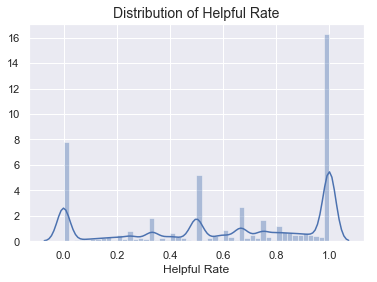

In [6]:
ax = sns.distplot(df["helpfulRate"])
ax.set(xlabel="Helpful Rate")
ax.axes.set_title("Distribution of Helpful Rate", fontsize=14)
plt.show()

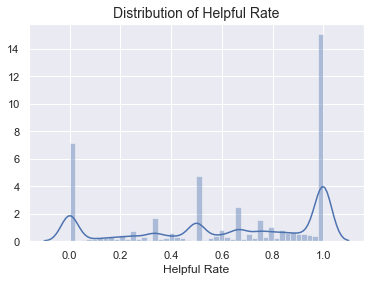

In [7]:
#Take 20% sample of the dataset
df = df.sample(frac=0.2)
ax = sns.distplot(df["helpfulRate"])
ax.set(xlabel="Helpful Rate")
ax.axes.set_title("Distribution of Helpful Rate", fontsize=14)
plt.show()

Distribution looks same. We are good to go. 

***
Let's check the size of the sample dataset:

In [8]:
df["asin"].describe()

count         217749
unique         39833
top       B009934S5M
freq             339
Name: asin, dtype: object

### <a id="2"></a>2. Effect of Language on Helpfulness

***
Define a function to detect language of the review texts:

In [9]:
#error handling to avoid exception; "LangDetectException: No features in text"
#which means that there is not enough features in text to detect language
#the language feature for those texts will be labeled as "n/a"
def langDetect(x):
    try:
        return detect(x)
    except:
        return "n/a"

***
Detect languages:

In [10]:
#Apply language detect function to all the reviews in the dataset
df["language"] = df["reviewText"].apply(lambda text: langDetect(text))
df.head()

,reviewerID,asin,reviewText,overall,summary,unixReviewTime,helpful1,helpful2,helpfulRate,language
155255,A34PAZQ73SL163,0792846117,This is the perfect blend of physical and inte...,5.0,A Spendid Farce.,1090108800,3,3,1.000000,en
1308166,A2DG4LCT2Z7SJS,B002ZG98LO,This was the first Predator movie in more than...,3.0,Pretty Good,1357516800,0,1,0.000000,en
593145,A2F3HLHRHQMR6O,B00005JKZH,Dr. Joe (Kevin Costner) is about to learn ther...,5.0,the new Kevin Costner vehicle,1028505600,1,1,1.000000,en
1190804,A2O6K23YDIP81M,B001FB55LW,I just saw this movie at the theater yesterday...,5.0,Invite yourself to 100 minutes of pure laughter!!,1234656000,2,3,0.666667,en
435509,A2NOZB6VZCTOI4,6304773455,I watched 'Bio-Dome' under extreme protest. I ...,1.0,"Makes Carrot Top Seem Handsome, and Adam Sandl...",1081036800,6,26,0.230769,en


***
It seems English is the dominant language for the reviews in the dataset:

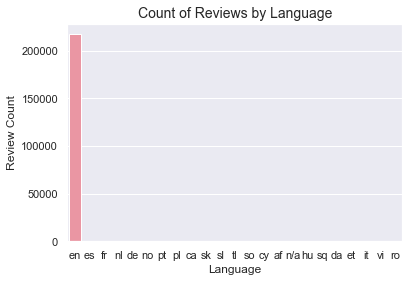

In [11]:
ax = sns.countplot(df["language"])
ax.set(xlabel="Language", ylabel="Review Count")
ax.axes.set_title("Count of Reviews by Language", fontsize=14)
plt.show()

***
Lets check the number of reviews with languages other than English:

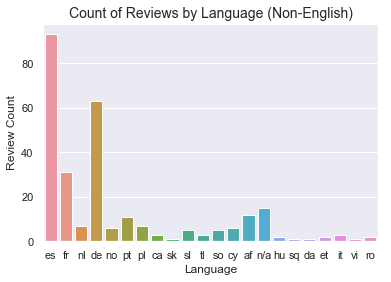

In [12]:
ax = sns.countplot(df.loc[df["language"] != "en"]["language"])
ax.set(xlabel="Language", ylabel="Review Count")
ax.axes.set_title("Count of Reviews by Language (Non-English)", fontsize=14)
plt.show()

It seems there are only a few reviews exist for other languages. Thus, the following chart doesn't make sense in terms of the connection between language and the helpfulness. For example, there is only one review in Slovak and there must be only one vote which is helpful, so the helpful rate for Slovak is 100%.

It seems it's not possible to decide if the language affects helpfulness, because of the lack of observations.

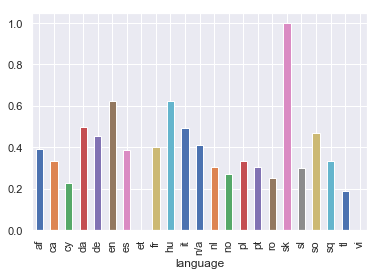

In [13]:
df.groupby(["language"])["helpfulRate"].mean().plot.bar()
ax.set(xlabel="Language", ylabel="Helpful Rate")
ax.axes.set_title("Average of Helpful Rate by Language", fontsize=14)
plt.show()

***
Lets continue with only English:

In [14]:
df = df.loc[df["language"] == "en"]

***
### <a id="3"></a>3. Text Pre-Processing

Fix contactions:

In [15]:
df["reviewText"] = df["reviewText"].apply(lambda text: contractions.fix(text))
df.head()

,reviewerID,asin,reviewText,overall,summary,unixReviewTime,helpful1,helpful2,helpfulRate,language
155255,A34PAZQ73SL163,0792846117,This is the perfect blend of physical and inte...,5.0,A Spendid Farce.,1090108800,3,3,1.000000,en
1308166,A2DG4LCT2Z7SJS,B002ZG98LO,This was the first Predator movie in more than...,3.0,Pretty Good,1357516800,0,1,0.000000,en
593145,A2F3HLHRHQMR6O,B00005JKZH,Dr. Joe (Kevin Costner) is about to learn ther...,5.0,the new Kevin Costner vehicle,1028505600,1,1,1.000000,en
1190804,A2O6K23YDIP81M,B001FB55LW,I just saw this movie at the theater yesterday...,5.0,Invite yourself to 100 minutes of pure laughter!!,1234656000,2,3,0.666667,en
435509,A2NOZB6VZCTOI4,6304773455,I watched 'Bio-Dome' under extreme protest. I ...,1.0,"Makes Carrot Top Seem Handsome, and Adam Sandl...",1081036800,6,26,0.230769,en


***
Convert all the text to lowercase and tokenize words for each review text with word_tokenize function of nltk library:

In [16]:
df["reviewText"] = df["reviewText"].str.lower()
df["tokenized_text"] = df["reviewText"].apply(word_tokenize)
df.head()

,reviewerID,asin,reviewText,overall,summary,unixReviewTime,helpful1,helpful2,helpfulRate,language,tokenized_text
155255,A34PAZQ73SL163,0792846117,this is the perfect blend of physical and inte...,5.0,A Spendid Farce.,1090108800,3,3,1.000000,en,"[this, is, the, perfect, blend, of, physical, ..."
1308166,A2DG4LCT2Z7SJS,B002ZG98LO,this was the first predator movie in more than...,3.0,Pretty Good,1357516800,0,1,0.000000,en,"[this, was, the, first, predator, movie, in, m..."
593145,A2F3HLHRHQMR6O,B00005JKZH,dr. joe (kevin costner) is about to learn ther...,5.0,the new Kevin Costner vehicle,1028505600,1,1,1.000000,en,"[dr., joe, (, kevin, costner, ), is, about, to..."
1190804,A2O6K23YDIP81M,B001FB55LW,i just saw this movie at the theater yesterday...,5.0,Invite yourself to 100 minutes of pure laughter!!,1234656000,2,3,0.666667,en,"[i, just, saw, this, movie, at, the, theater, ..."
435509,A2NOZB6VZCTOI4,6304773455,i watched 'bio-dome' under extreme protest. i ...,1.0,"Makes Carrot Top Seem Handsome, and Adam Sandl...",1081036800,6,26,0.230769,en,"[i, watched, 'bio-dome, ', under, extreme, pro..."


***
Now we'll apply some functions to remove punctuations:

In [17]:
df["tokenized_text"] = df["tokenized_text"].apply(lambda words: [word for word in words if word not in string.punctuation])
df["tokenized_text"] = df["tokenized_text"].apply(lambda words: [word.replace('[^\w\s]','') for word in words])
df["tokenized_text"] = df["tokenized_text"].apply(lambda words: [word.replace("'",'') for word in words])
df["tokenized_text"] = df["tokenized_text"].apply(lambda words: [word.replace("`",'') for word in words])
df["tokenized_text"] = df["tokenized_text"].apply(lambda words: [word.strip() for word in words])
df["tokenized_text"] = df["tokenized_text"].apply(lambda textList: list(filter(None, textList)))
df.head()

,reviewerID,asin,reviewText,overall,summary,unixReviewTime,helpful1,helpful2,helpfulRate,language,tokenized_text
155255,A34PAZQ73SL163,0792846117,this is the perfect blend of physical and inte...,5.0,A Spendid Farce.,1090108800,3,3,1.000000,en,"[this, is, the, perfect, blend, of, physical, ..."
1308166,A2DG4LCT2Z7SJS,B002ZG98LO,this was the first predator movie in more than...,3.0,Pretty Good,1357516800,0,1,0.000000,en,"[this, was, the, first, predator, movie, in, m..."
593145,A2F3HLHRHQMR6O,B00005JKZH,dr. joe (kevin costner) is about to learn ther...,5.0,the new Kevin Costner vehicle,1028505600,1,1,1.000000,en,"[dr., joe, kevin, costner, is, about, to, lear..."
1190804,A2O6K23YDIP81M,B001FB55LW,i just saw this movie at the theater yesterday...,5.0,Invite yourself to 100 minutes of pure laughter!!,1234656000,2,3,0.666667,en,"[i, just, saw, this, movie, at, the, theater, ..."
435509,A2NOZB6VZCTOI4,6304773455,i watched 'bio-dome' under extreme protest. i ...,1.0,"Makes Carrot Top Seem Handsome, and Adam Sandl...",1081036800,6,26,0.230769,en,"[i, watched, bio-dome, under, extreme, protest..."


***
Remove stop words:

In [18]:
stop = stopwords.words('english')
df["tokenized_text"] = df["tokenized_text"].apply(lambda words: [word for word in words if word not in stop])
df.head()

,reviewerID,asin,reviewText,overall,summary,unixReviewTime,helpful1,helpful2,helpfulRate,language,tokenized_text
155255,A34PAZQ73SL163,0792846117,this is the perfect blend of physical and inte...,5.0,A Spendid Farce.,1090108800,3,3,1.000000,en,"[perfect, blend, physical, intellectual, comed..."
1308166,A2DG4LCT2Z7SJS,B002ZG98LO,this was the first predator movie in more than...,3.0,Pretty Good,1357516800,0,1,0.000000,en,"[first, predator, movie, 20, years, awful, eas..."
593145,A2F3HLHRHQMR6O,B00005JKZH,dr. joe (kevin costner) is about to learn ther...,5.0,the new Kevin Costner vehicle,1028505600,1,1,1.000000,en,"[dr., joe, kevin, costner, learn, things, heav..."
1190804,A2O6K23YDIP81M,B001FB55LW,i just saw this movie at the theater yesterday...,5.0,Invite yourself to 100 minutes of pure laughter!!,1234656000,2,3,0.666667,en,"[saw, movie, theater, yesterday, high, expecta..."
435509,A2NOZB6VZCTOI4,6304773455,i watched 'bio-dome' under extreme protest. i ...,1.0,"Makes Carrot Top Seem Handsome, and Adam Sandl...",1081036800,6,26,0.230769,en,"[watched, bio-dome, extreme, protest, really, ..."


***
Lemmatize words:

In [19]:
lemmatizer = WordNetLemmatizer()
df["tokenized_text"] = df["tokenized_text"].apply(lambda words: [lemmatizer.lemmatize(word) for word in words])
df.head()

,reviewerID,asin,reviewText,overall,summary,unixReviewTime,helpful1,helpful2,helpfulRate,language,tokenized_text
155255,A34PAZQ73SL163,0792846117,this is the perfect blend of physical and inte...,5.0,A Spendid Farce.,1090108800,3,3,1.000000,en,"[perfect, blend, physical, intellectual, comed..."
1308166,A2DG4LCT2Z7SJS,B002ZG98LO,this was the first predator movie in more than...,3.0,Pretty Good,1357516800,0,1,0.000000,en,"[first, predator, movie, 20, year, awful, easi..."
593145,A2F3HLHRHQMR6O,B00005JKZH,dr. joe (kevin costner) is about to learn ther...,5.0,the new Kevin Costner vehicle,1028505600,1,1,1.000000,en,"[dr., joe, kevin, costner, learn, thing, heave..."
1190804,A2O6K23YDIP81M,B001FB55LW,i just saw this movie at the theater yesterday...,5.0,Invite yourself to 100 minutes of pure laughter!!,1234656000,2,3,0.666667,en,"[saw, movie, theater, yesterday, high, expecta..."
435509,A2NOZB6VZCTOI4,6304773455,i watched 'bio-dome' under extreme protest. i ...,1.0,"Makes Carrot Top Seem Handsome, and Adam Sandl...",1081036800,6,26,0.230769,en,"[watched, bio-dome, extreme, protest, really, ..."


***
### <a id="4"></a>4. Frequent Words Used In the Reviews with Poor Helpfulness

Now we're done with the text processing. Each row has a lot of words so we need to put each word to a row with helpful rate.

In [20]:
rows = []
df.apply(lambda row: [rows.append([row[8], text]) for text in row[10]] , axis=1)
df2 = pd.DataFrame(rows, columns=["helpfulRate", "word"])
df2.head()

,helpfulRate,word
0,1.0,perfect
1,1.0,blend
2,1.0,physical
3,1.0,intellectual
4,1.0,comedy


***
Calculate count of occurences and the average of helpful rate for each unique word. Sort data by helpful rate in ascending order then word count in descending order:

In [21]:
df3 = df2.groupby(["word"]).agg({"word":"count", "helpfulRate": "mean"}).rename(columns={"word": "wordCount"}).reset_index()
df3.sort_values(["helpfulRate", "wordCount"], ascending=[True, False], inplace=True)
df3.head()

,word,wordCount,helpfulRate
34680,8206,48,0.0
204835,fabien,20,0.0
398752,pagie,12,0.0
239823,glauben,11,0.0
313367,lathos,11,0.0


***
Let's check only words with more than 99 occurences to see the affect of the specific words in poor helpfulness more significantly:

In [22]:
df3 = df3.loc[df3["wordCount"] >= 100]
df3.sort_values(["helpfulRate"], ascending=[True], inplace=True)
df3.head(100)

,word,wordCount,helpfulRate
32319,640,167,0.418335
513350,stunk,119,0.430522
602542,zombieland,111,0.441464
304156,khz,302,0.442995
259425,hedwig,103,0.456592
597088,y2j,124,0.464546
455602,rogen,203,0.466083
396775,overrated,568,0.469341
578120,waste,5143,0.469789
390481,optimus,164,0.475468


It seems there is a connection between poor helpfulness and criticizing with a negative language. There are some negative words with high frequency like "overrated", "waste", "unfunny", "boring", "stupidest", "pointless", and "hype".

Also, there are a lot of words which seem like related to the plot of the movie or the TV show. That means writing a spoiler is a big danger! 

### <a id="5"></a>5. Topic Modeling

We'll use LDA model for topic modeling
(https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)
(https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/).

Simply, we'll try to find frequent word combinations used in each text. Then we'll try to understand the related topic for those word combinations.

Since we are trying to get insights for poor helpfulness, we'll use only reviews with the poor helpful rate. If we use all the data, this model gives an overall informations for the most used topics in all the reviews.

In [ ]:
textlist = df.loc[df["helpfulRate"] <= 0.33]["tokenized_text"]
dictionary = gensim.corpora.Dictionary(textlist)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in textlist]

In [24]:
lda = gensim.models.ldamodel.LdaModel
ldamodel = lda(doc_term_matrix, num_topics=20, id2word = dictionary, passes=50)

Most of the word combinations seem to have a topic related to the plot of the movie or TV show. Again, spoilers are dangerous.

Also, there are some combinations which seem like subjective experience. When writing a review, it's better to write about facts which helps the reader to make his/her decision.

In [25]:
for i in ldamodel.print_topics(num_topics=20, num_words=8):
    print(i)
    print("")

(0, '0.032*"zombie" + 0.029*"vampire" + 0.011*"dead" + 0.008*"blade" + 0.006*"dracula" + 0.006*"shark" + 0.006*"jaw" + 0.006*"dawn"')

(1, '0.011*"johnny" + 0.009*"depp" + 0.008*"matt" + 0.008*"ben" + 0.007*"charlie" + 0.007*"damon" + 0.007*"wilson" + 0.006*"tim"')

(2, '0.170*"--" + 0.004*"anthony" + 0.004*"paris" + 0.004*"university" + 0.004*"hopkins" + 0.003*"alice" + 0.003*"ralph" + 0.003*"bogart"')

(3, '0.113*"quot" + 0.035*"match" + 0.016*"vs." + 0.015*"v" + 0.009*"team" + 0.007*"win" + 0.006*"title" + 0.006*"good"')

(4, '0.094*"..." + 0.064*"show" + 0.050*"season" + 0.048*"episode" + 0.045*"series" + 0.016*"tv" + 0.010*"2" + 0.009*"star"')

(5, '0.040*"film" + 0.011*"character" + 0.009*"one" + 0.006*"story" + 0.006*"scene" + 0.005*"well" + 0.005*"much" + 0.005*"time"')

(6, '0.018*"comic" + 0.018*"batman" + 0.013*"superman" + 0.013*"bruce" + 0.008*"jesus" + 0.008*"iron" + 0.007*"man" + 0.006*"x-men"')

(7, '0.066*"movie" + 0.019*"like" + 0.018*"good" + 0.016*"one" + 0.014*"wou